## CHANGES

- add sigmoid to custom head to prevent negative preds

## SETUP

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split(' ')[0])

fastai: 1.0.48
pytorch: 1.0.1.post2
python: 3.6.7


In [4]:
version = 'v7'       # this should match the notebook filename

seed = 42
arch = models.resnet50
size = 224  # (y, x)
bs = 32
num_workers = 6     # set to available cores

transform = 'spectogram'  # which time series to visual transformation to use

In [5]:
# set seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## DATA

Assumes the following has been generated using `gen_spectogram`:
- `X_train.csv`
- `y_train.csv`
- `train_images`
- `test_images`

In [33]:
# set paths
path = pathlib.Path.home()/'.fastai/data/kaggle_earthquake'
img_path = path/f'train_images/{transform}'
save_path = path/'saved_models'
os.makedirs(save_path, exist_ok=True)

In [9]:
# load segment CSVs
#pd.options.display.precision = 15
X_train = pd.read_csv(path/'X_train.csv', index_col=0)
y_train = pd.read_csv(path/'y_train.csv', index_col=0)

In [34]:
#X_train.head()

In [36]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


## MODEL

In [12]:
# sigmoid on model output spits out values betwen 0 and 1
scale = 22

In [13]:
# scale down the labels
def gen_label(path):
    id = int(path.name.split('_')[1].split('.')[0])
    ttf = y_train.iloc[id]['time_to_failure']
    return ttf / scale

In [14]:
gen_label(img_path/'seg_0.png')

0.06503623572272726

In [15]:
# no data augmentation
tfms = get_transforms(do_flip=False, p_affine=0., p_lighting=0.)

In [16]:
fake_label = 0.
valid_idx = range(3000, len(y_train))

src = (ImageList.from_folder(img_path)
        .split_by_idx(valid_idx=valid_idx)
        .label_from_func(gen_label, label_cls=FloatList)
        .add_test_folder(f'../../test_images/{transform}', label=fake_label))

In [17]:
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [18]:
# verify datasets loaded properly
n_train_items = len(data.train_ds)
n_valid_items = len(data.valid_ds)
n_test_items = len(data.test_ds)

print('train: ', n_train_items)
print('valid: ', n_valid_items)
print('test:  ', n_test_items)
print('')
print('TOTAL: ', n_train_items + n_valid_items + n_test_items)

train:  3000
valid:  1194
test:   2624

TOTAL:  6818


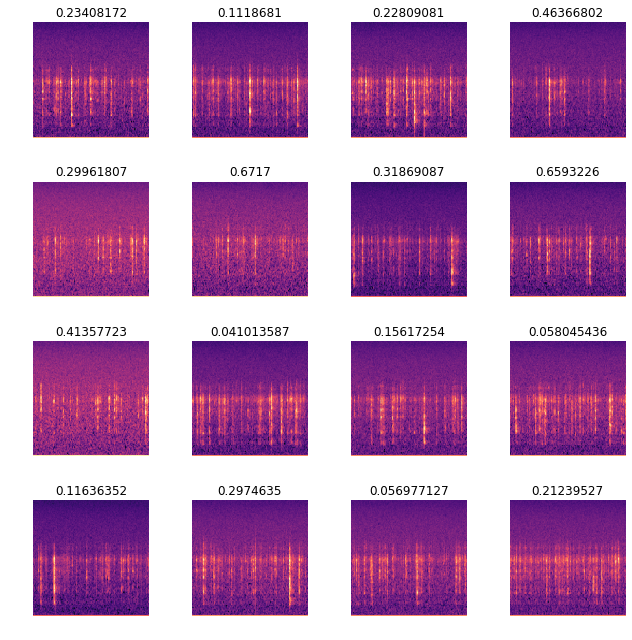

In [19]:
# verify images and labels match up
data.show_batch(4, figsize=(9, 9))

In [20]:
# define metrics
def mae_scaled(preds, targs):
    return mean_absolute_error(preds.view(-1)*scale, targs.view(-1)*scale)

In [21]:
# L1 loss is sum of the all the absolute differences
# more robust to outliers
l1loss = nn.L1Loss()
def l1_loss(preds, targs):
    return l1loss(preds.view(-1), targs.view(-1))

# L2 loss is sum of the all the squared differences
# less robust to outliers
l2loss = nn.MSELoss()
def l2_loss(preds, targs):
    return l2loss(preds.view(-1), targs.view(-1))

In [22]:
# return correct size of fully connected layer based on pre-trained model
def final_conv_layer_size(arch):
    if arch == models.resnet18 and size == (217, 223): return 512*14*21
    elif arch == models.resnet34 and size == (217, 223): return 512*7*7  
    elif arch == models.resnet50 and size == (217, 223): return 2048*7*7
    elif arch == models.resnet50 and size == 224: return 2048*7*7

In [23]:
# define custom heads
small_head = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1))

small_head_sigmoid = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1),  nn.Sigmoid())

medium_head = nn.Sequential(
  nn.AvgPool2d(7, 7),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 256),
  nn.ReLU(),
  nn.BatchNorm1d(256),
  nn.Dropout(0.5),
  nn.Linear(256, 1))

big_head = nn.Sequential(
  nn.AvgPool2d(7, 7),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.BatchNorm1d(512),
  nn.Dropout(0.5),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.BatchNorm1d(128),
  nn.Dropout(0.5),
  nn.Linear(128, 1))


big_head_sigmoid = nn.Sequential(
  nn.AvgPool2d(7, 7),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.BatchNorm1d(512),
  nn.Dropout(0.5),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.BatchNorm1d(128),
  nn.Dropout(0.5),
  nn.Linear(128, 1),
  nn.Sigmoid())

In [24]:
# define callback parameters
lr_min_delta = 0.0001
lr_patience = 200
lr_factor = 0.2

stop_min_delta = 0.0001
stop_patience = 10

In [25]:
# create learner with callbacks
learn = cnn_learner(data, arch,
                    custom_head=big_head_sigmoid,
                    loss_func=l1_loss,
                    metrics=[mean_squared_error, mean_absolute_error, mae_scaled],
                    callback_fns=[
                        partial(ReduceLROnPlateauCallback,
                                monitor='mean_absolute_error',
                                mode='min',
                                min_delta=lr_min_delta,
                                patience=lr_patience,
                                factor=lr_factor),
                        partial(EarlyStoppingCallback,
                                monitor='mean_absolute_error',
                                mode='min',
                                min_delta=stop_min_delta,
                                patience=stop_patience)])

In [26]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 112, 112]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 112, 112]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 112, 112]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 56, 56]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 56, 56]      128        True      
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      36,864     False     
______________________________________________________________

## TRAIN

#### Helper functions

In [27]:
def plot_lr_find(learn):
    learn.lr_find()
    learn.recorder.plot()

In [28]:
def fit_one_cycle(learn, stage, n_epochs, max_lr):
    learn.fit_one_cycle(n_epochs, max_lr=max_lr, callbacks=[
        SaveModelCallback(learn,
                          monitor='mean_absolute_error',
                          mode='min',
                          every='improvement',
                          name=save_path/f'{version}-{stage}-best')])
    learn.recorder.plot_losses()
    learn.recorder.plot_lr(show_moms=True)

#### Stage 1.1

In [29]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


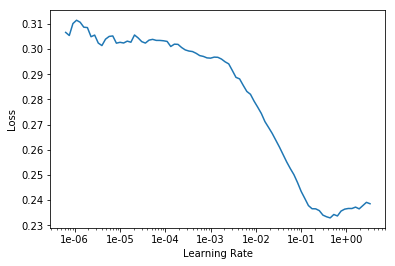

In [30]:
plot_lr_find(learn)

In [31]:
stage = 's1.1'
n_epochs = 6   # 4
max_lr = slice(2e-2)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mae_scaled,time
0,0.160477,0.113863,0.021223,0.113863,2.504982,00:16
1,0.120307,0.102002,0.018672,0.102002,2.244043,00:15
2,0.107748,0.106587,0.019824,0.106587,2.344924,00:15
3,0.097539,0.096505,0.017476,0.096505,2.123115,00:15
4,0.087435,0.101184,0.017503,0.101184,2.226055,00:15
5,0.078678,0.100691,0.017479,0.100691,2.215209,00:15


Better model found at epoch 0 with mean_absolute_error value: 0.11386285722255707.
Better model found at epoch 1 with mean_absolute_error value: 0.10200195759534836.
Better model found at epoch 3 with mean_absolute_error value: 0.09650518745183945.


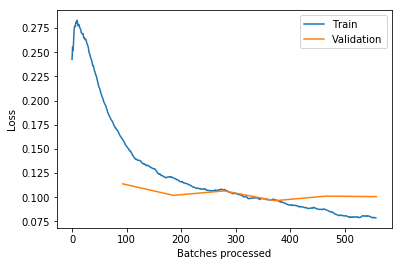

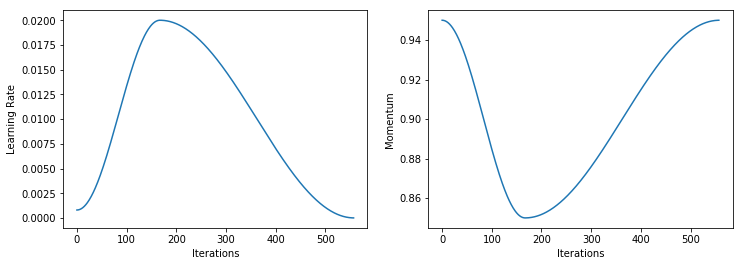

In [32]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

#### Stage 1.2

In [37]:
learn.load(save_path/f'{version}-s1.1-best');

In [38]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


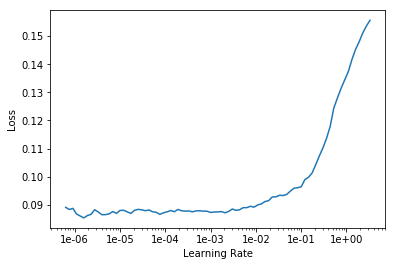

In [39]:
plot_lr_find(learn)

In [41]:
stage = 's1.2'
n_epochs = 6   # 4
max_lr = slice(2e-4)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mae_scaled,time
0,0.089333,0.096995,0.016870,0.096995,2.133895,00:15
1,0.086462,0.099522,0.017105,0.099522,2.189492,00:15
2,0.084725,0.098770,0.017220,0.098770,2.172939,00:15
3,0.083465,0.102030,0.017356,0.102030,2.244662,00:15
4,0.081273,0.102619,0.017588,0.102619,2.257610,00:15
5,0.081760,0.102525,0.017553,0.102525,2.255553,00:15


Better model found at epoch 0 with mean_absolute_error value: 0.09699521213769913.


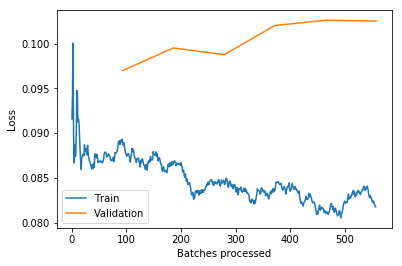

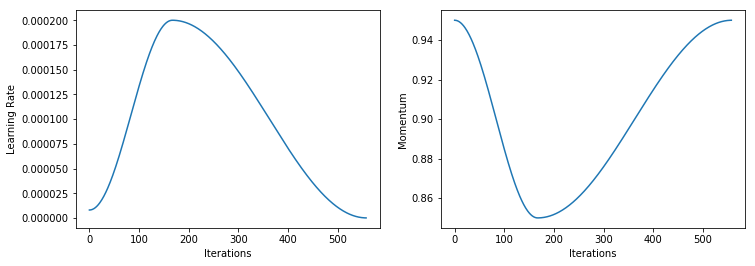

In [42]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

#### Stage 2.1

In [ ]:
learn.load(save_path/f'{version}-s1.2-best');

In [ ]:
learn.unfreeze()

In [ ]:
plot_lr_find(learn)

In [ ]:
stage = 's2.1'
n_epochs = 6
max_lr = slice(1e-6, 1e-5)

In [ ]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

## RESULTS

In [43]:
learn.load(save_path/f'{version}-s1.1-best');

In [44]:
# plot histograms of results
def plot_histograms(dataset):
    preds, targs = learn.get_preds(ds_type=dataset)
    preds = preds * scale
    targs = targs * scale
    print('min/max pred: ', min(preds).item(), max(preds).item())
    print('min/max targ: ', min(targs).item(), max(targs).item())
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
    fig.suptitle("Histograms of segment's time to failure")

    ax1.hist(preds.squeeze(), bins=50); ax1.set_xlabel('preds TTF'); ax1.set_ylabel('No. of segments')
    ax2.hist(targs, bins=50); ax2.set_xlabel('targs TTF'); ax2.set_ylabel('No. of segments')

#### Training Set

min/max pred:  0.6698823571205139 11.336651802062988
min/max targ:  0.006397657096385956 16.103195190429688


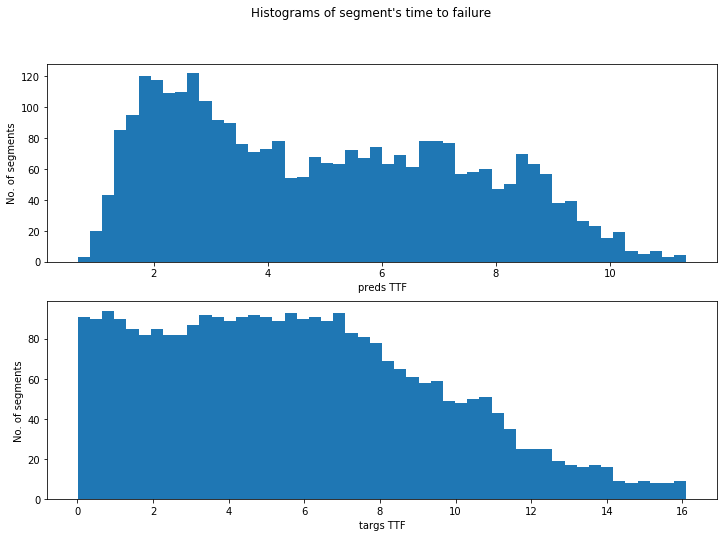

In [45]:
plot_histograms(DatasetType.Fix)

#### Validation Set

min/max pred:  0.700597882270813 11.993041038513184
min/max targ:  0.007298300042748451 14.71989917755127


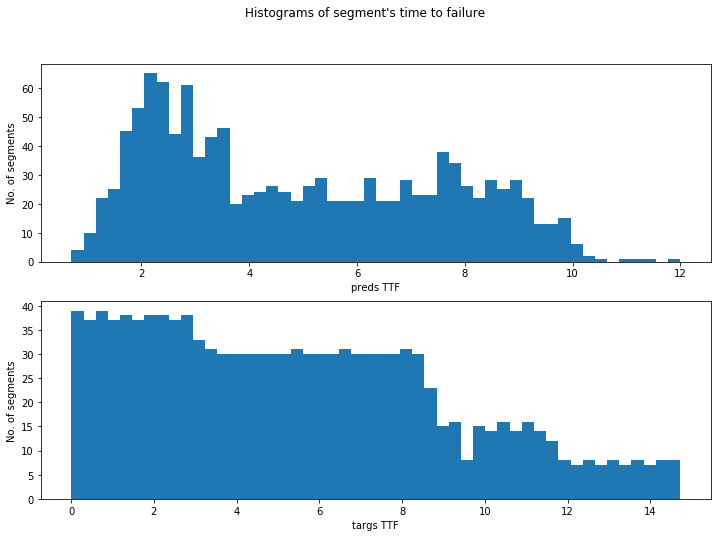

In [46]:
plot_histograms(DatasetType.Valid)

#### Test Set

min/max pred:  0.6789827346801758 11.941895484924316
min/max targ:  0.0 0.0


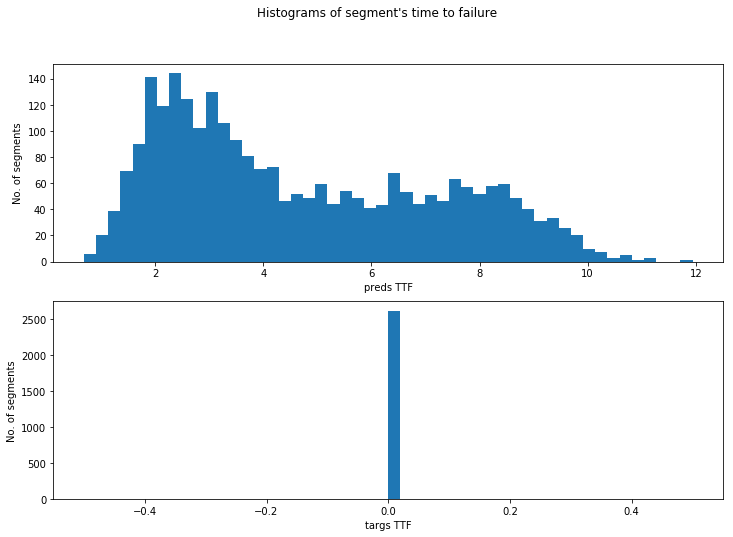

In [47]:
plot_histograms(DatasetType.Test)

## SUBMISSION

In [50]:
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [51]:
# load sample submission
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')

In [52]:
# assume order of test set is unchanged
submission['time_to_failure'] = [test_preds[i].item() * scale for i in range(len(test_preds))]

In [53]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,5.028216421604156
seg_0012b5,3.033158987760544
seg_00184e,3.797795355319977
seg_003339,9.488644897937775
seg_0042cc,5.124364048242569


In [54]:
submission_file = path/f'{version}-submission.csv'
submission.to_csv(submission_file)

In [55]:
# submit to leaderboard
! cd $path; kaggle competitions submit -c LANL-Earthquake-Prediction -f $submission_file -m "Message"

100%|██████████████████████████████████████| 75.0k/75.0k [00:06<00:00, 11.4kB/s]
Successfully submitted to LANL Earthquake Prediction

In [ ]:
# MAE        :  2.12   
# Public Score: 1.790  